## Прогноз средней зарплаты в России 

In [3]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\Dell\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Загрузка данных и график

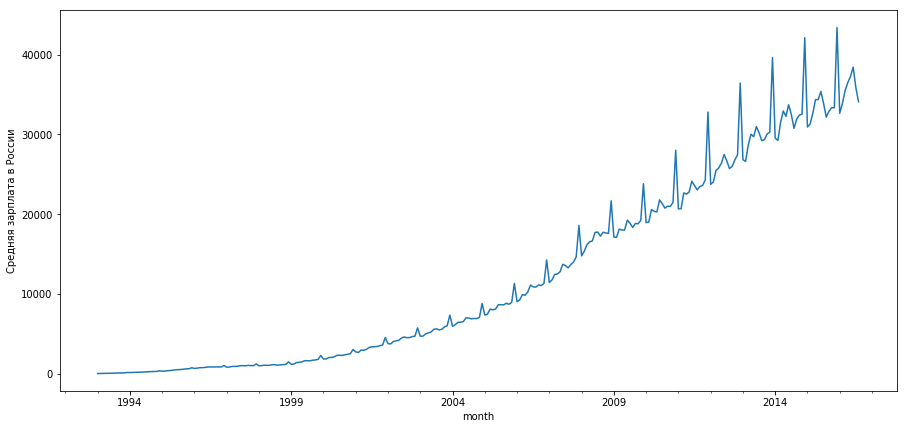

In [47]:
data = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
plt.ylabel(u'Средняя зарплата в России')
pylab.show()

In [48]:
data.tail()

,WAG_C_M
month,
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0
2016-07-01,35888.0
2016-08-01,34095.0


Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

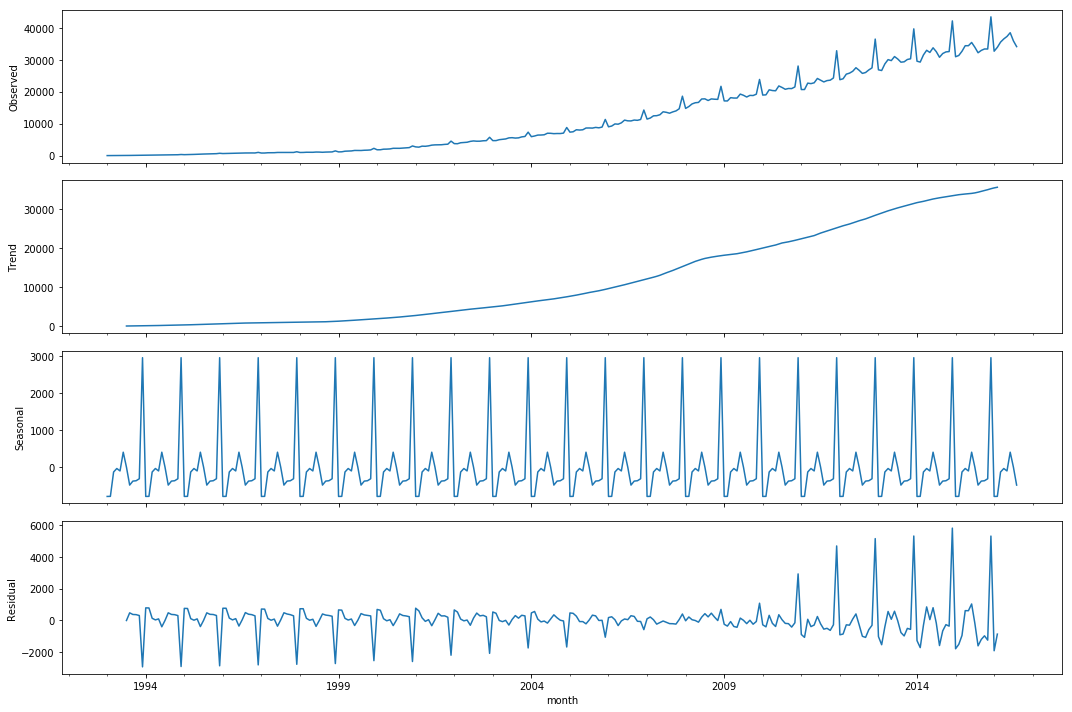

In [49]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['WAG_C_M'])[1])

Вывод: по графику наблюдается ярко выраженный тренд, сезонность, остатки неравномерны, стационарность отсутствует

### Стабилизация дисперсии

Проведем преобразование Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


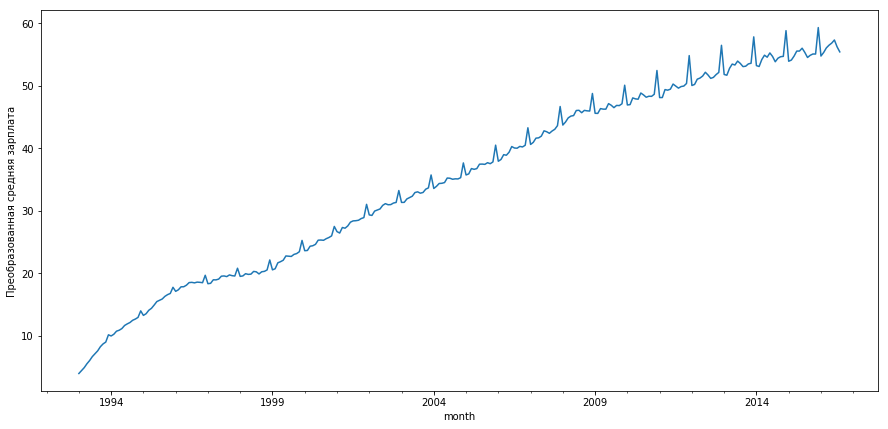

In [19]:
data['wag_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize(15,7))
data.wag_box.plot()
plt.ylabel(u'Преобразованная средняя зарплата')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box)[1])

Гипотеза стационарности отвегается, что также подтверждается визуально

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

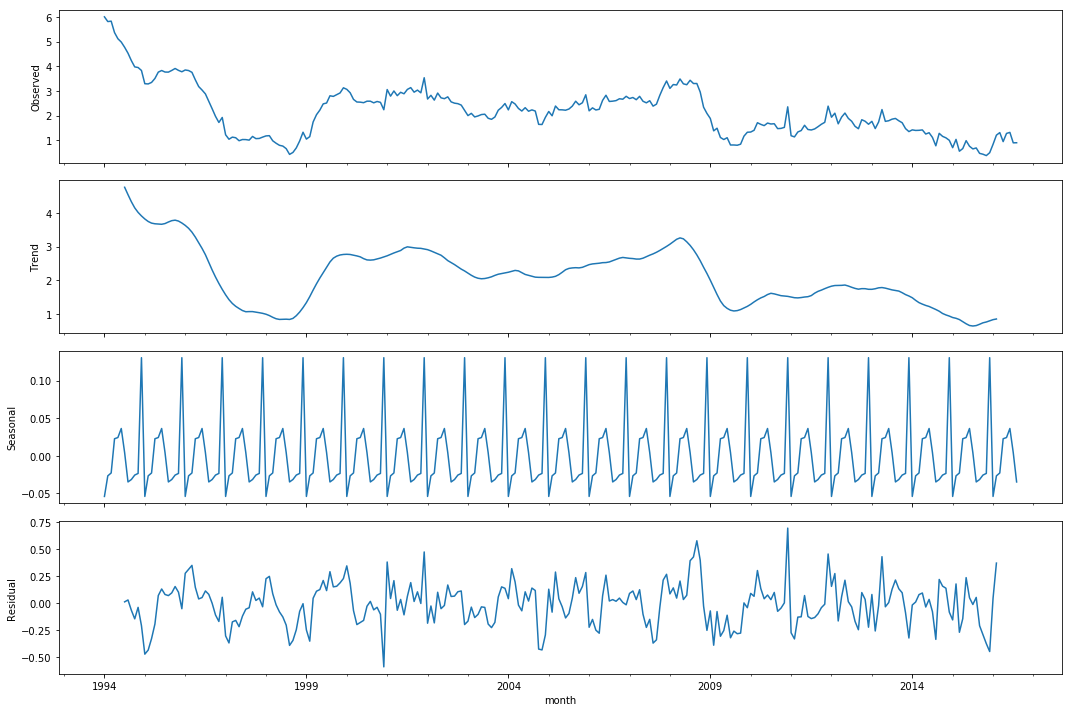

In [21]:
data['wag_box_diff'] = data.wag_box - data.wag_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

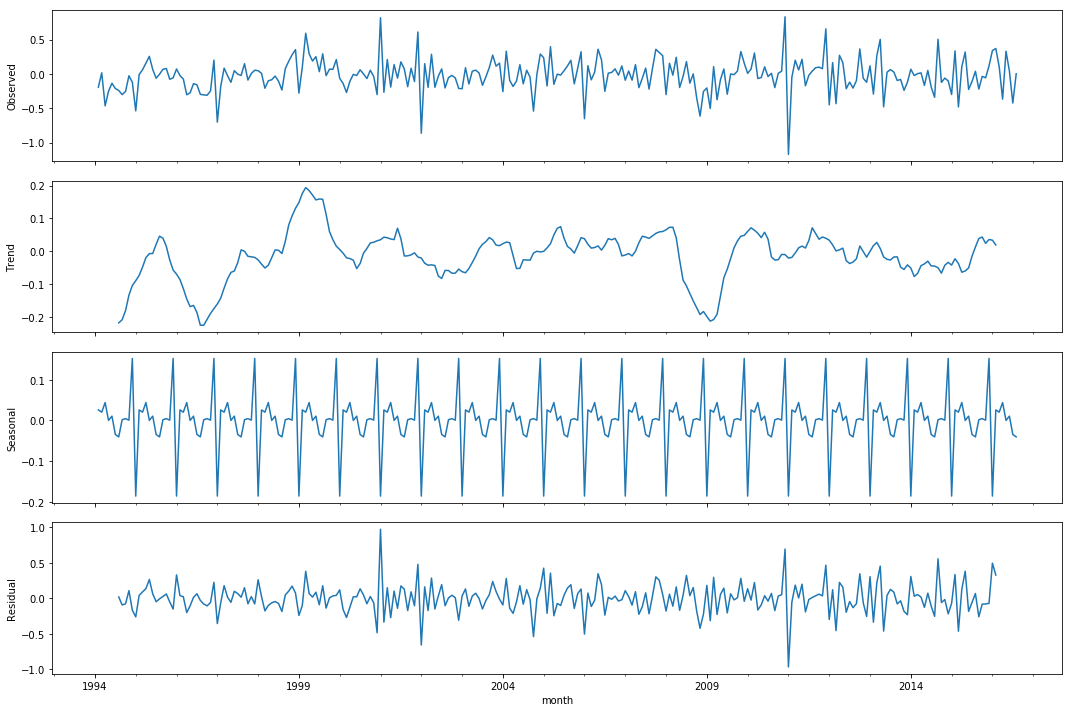

In [24]:
data['wag_box_diff2'] = data.wag_box_diff - data.wag_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wag_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wag_box_diff2[13:])[1])

Согласно критерию Дики-Фулера и по визуальным данным стационарность достигнута

### Подбор параметров модели

ACF и PACF

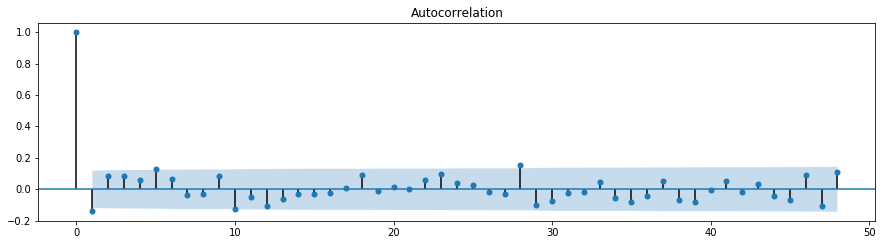

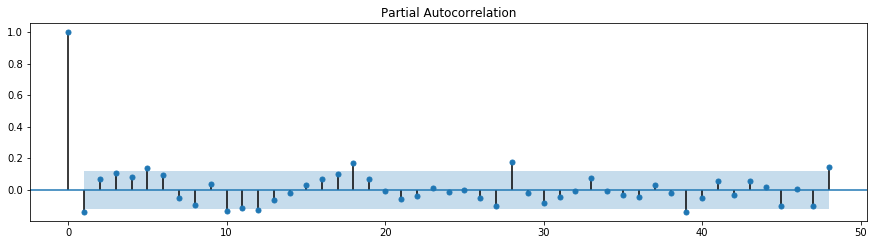

In [27]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wag_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 10, P = 0, p = 11

In [28]:
ps = range(0, 12)
d=1
qs = range(0, 11)
Ps = range(0, 1)
D=1
Qs = range(0, 1)

In [29]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

132

In [30]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wag_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 10, 0, 0))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 10, 0, 0))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 3, 0, 0))
('wrong parameters:', (5, 4, 0, 0))
('wrong parameters:', (5, 9, 0, 0))
('wrong parameters:', (6, 3, 0, 0))
('wrong parameters:', (6, 4, 0, 0))
('wrong parameters:', (6, 7, 0, 0))
('wrong parameters:', (6, 8, 0, 0))
('wrong parameters:', (6, 9, 0, 0))
('wrong parameters:', (6, 10, 0, 0))
('wrong parameters:', (7, 3, 0, 0))
('wrong parameters:', (7, 4, 0, 0))
('wrong parameters:', (7, 6, 0, 0))
('wrong parameters:', (7, 7, 0, 0))
('wrong parameters:', (7, 8, 0, 0))
('wrong parameters:', (7, 9, 0, 0))
('wrong parameters:', (8, 4, 0, 0))
('wrong parameters:', (8, 5, 0, 0))
('wrong parameters:', (8, 6, 0, 0))
('wrong parameters:', (8,

In [34]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
49  (5, 5, 0, 0) -21.893755
22  (2, 3, 0, 0) -21.089867
57  (6, 5, 0, 0) -20.421242
23  (2, 4, 0, 0) -19.586581
32  (3, 3, 0, 0) -18.680180


Лучшая модель

In [33]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  21.947
Date:                            Sat, 22 Dec 2018   AIC                            -21.894
Time:                                    00:01:21   BIC                             17.730
Sample:                                01-01-1993   HQIC                            -5.985
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2031      8.468     -0.024      0.981     -16.800      16.394
ar.L2          0.2501      6.270   

Остатки

Критерий Стьюдента: p=0.243104
Критерий Дики-Фуллера: p=0.000000


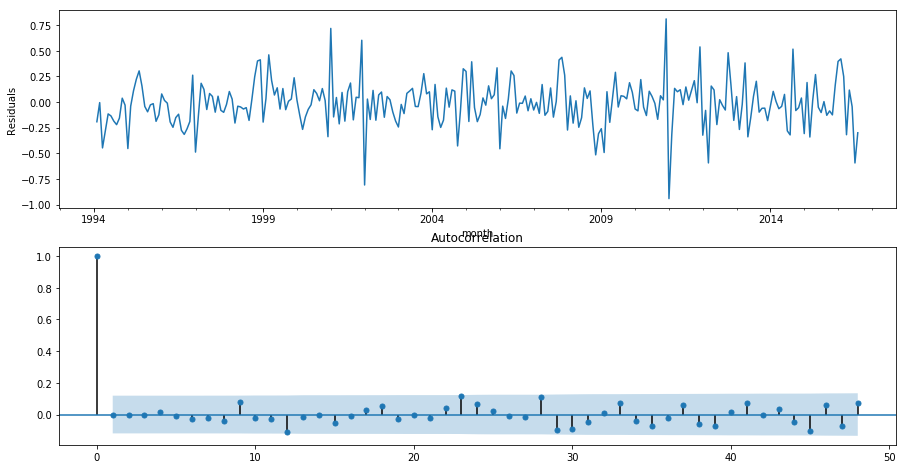

In [35]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены, стационарны, неавтокоррелированы

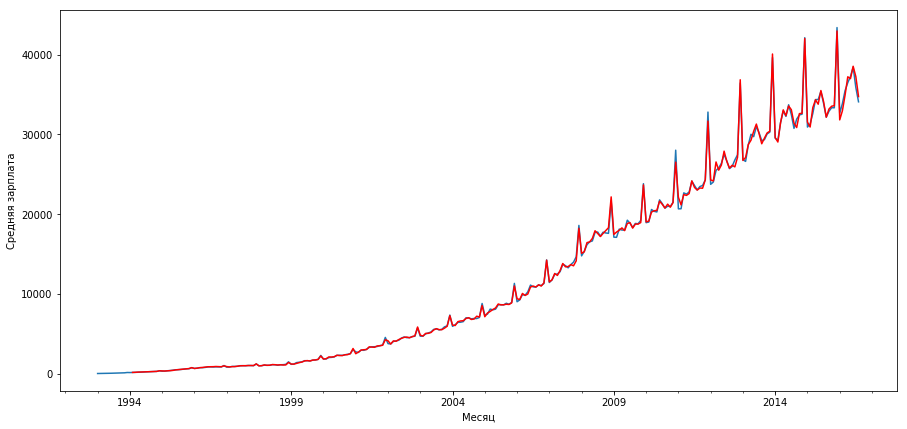

In [39]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data['WAG_C_M'].plot()
data.model[13:].plot(color='r')
plt.xlabel(u'Месяц')
plt.ylabel(u'Средняя зарплата')
pylab.show()

Модель достаточно хорошо описывает исходную последовательность

## Прогноз

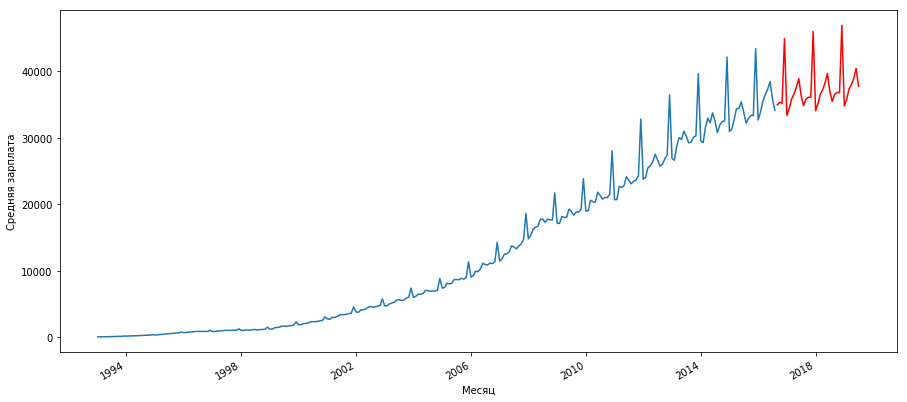

In [52]:
wag2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wag2.columns)
wag2 = pd.concat([wag2, future])
wag2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
wag2['WAG_C_M'].plot()
wag2['forecast'].plot(color='r')
plt.xlabel(u'Месяц')
plt.ylabel(u'Средняя зарплата')
pylab.show()

Результат: модель построена